<a href="https://colab.research.google.com/github/arumajirou/-daily-test/blob/main/espnet2_asr_realtime_demo_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ESPnet2-ASR リアルタイムデモ**
このノートでは、ESPnet2-ASRを使用したリアルタイムE2E-ASRのデモを行います。

- ESPnet2-ASR: https://github.com/espnet/espnet/tree/master/egs2/TEMPLATE/asr1

Author: Jiatong Shi ([@ftshijt](https://github.com/ftshijt))

In [1]:
#@title ライブラリのインストール
# 注意: pip はプリインストールされたライブラリのために imcompatible エラーを表示しますが、気にする必要はありません。
!pip install -q espnet==0.10.0
!pip install -q espnet_model_zoo

     |████████████████████████████████| 787 kB 4.5 MB/s 
     |████████████████████████████████| 86 kB 5.3 MB/s 
     |████████████████████████████████| 73 kB 2.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.9 MB 54.1 MB/s 
     |████████████████████████████████| 37.2 MB 139 kB/s 
     |████████████████████████████████| 214 kB 66.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.0 MB 72.7 MB/s 
     |████████████████████████████████| 125 kB 59.9 MB/s 
     |████████████████████████████████| 355 kB 54.4 MB/s 
     |████████████████████████████████| 41 kB 525 kB/s 
     |████████████████████████████████| 3.1 MB 73.1 MB/s 
     |████████████████████████████████| 235 kB 72.3 MB/s 
     |████████████████████████████████| 1.4 MB 63.5 MB/s 
 

## ASRモデルデモ

###**モデル選択**
[espnet_model_zoo](https://github.com/espnet/espnet_model_zoo/blob/master/espnet_model_zoo/table.csv)
に表示されている機種を選択してください。

本デモでは、英語、日本語、スペイン語、Mandrain、多言語ASRモデルをそれぞれ紹介する

In [2]:
#@title  英語のASRモデルを選択する { run: "auto" }

lang = 'en'
fs = 16000 #@param {type:"integer"}
tag = 'Shinji Watanabe/spgispeech_asr_train_asr_conformer6_n_fft512_hop_length256_raw_en_unnorm_bpe5000_valid.acc.ave' #@param ["Shinji Watanabe/spgispeech_asr_train_asr_conformer6_n_fft512_hop_length256_raw_en_unnorm_bpe5000_valid.acc.ave", "kamo-naoyuki/librispeech_asr_train_asr_conformer6_n_fft512_hop_length256_raw_en_bpe5000_scheduler_confwarmup_steps40000_optim_conflr0.0025_sp_valid.acc.ave"] {type:"string"}

In [3]:
#@title 日本語のASRモデルを選択する { run: "auto" }

lang = 'ja'
fs = 16000 #@param {type:"integer"}
tag = 'Shinji Watanabe/laborotv_asr_train_asr_conformer2_latest33_raw_char_sp_valid.acc.ave' #@param ["Shinji Watanabe/laborotv_asr_train_asr_conformer2_latest33_raw_char_sp_valid.acc.ave"] {type:"string"}

In [4]:
#@title スペイン語のASRモデルを選択する { run: "auto" }

lang = 'es'
fs = 16000 #@param {type:"integer"}
tag = 'ftshijt/mls_asr_transformer_valid.acc.best' #@param ["ftshijt/mls_asr_transformer_valid.acc.best"] {type:"string"}

In [5]:
#@title 北京語 ASRモデルを選択する { run: "auto" }

lang = 'zh'
fs = 16000 #@param {type:"integer"}
tag = 'Emiru Tsunoo/aishell_asr_train_asr_streaming_transformer_raw_zh_char_sp_valid.acc.ave' #@param ["	Emiru Tsunoo/aishell_asr_train_asr_streaming_transformer_raw_zh_char_sp_valid.acc.ave"] {type:"string"}

In [6]:
#@title 多言語 ASRモデルを選択する { run: "auto" }

lang = 'multilingual'
fs = 16000 #@param {type:"integer"}
tag = 'ftshijt/open_li52_asr_train_asr_raw_bpe7000_valid.acc.ave_10best' #@param ["	ftshijt/open_li52_asr_train_asr_raw_bpe7000_valid.acc.ave_10best"] {type:"string"}

### モデルの設定

In [7]:
import time
import torch
import string #テキストを扱う 標準ライブラリ
from espnet_model_zoo.downloader import ModelDownloader
from espnet2.bin.asr_inference import Speech2Text


d = ModelDownloader()
# モデルのダウンロードとビルドに時間がかかる場合があります
speech2text = Speech2Text(
    **d.download_and_unpack(tag),
    device="cuda",
    minlenratio=0.0,
    maxlenratio=0.0,
    ctc_weight=0.3,
    beam_size=10,
    batch_size=0,
    nbest=1
)

def text_normalizer(text):
    text = text.upper()
    return text.translate(str.maketrans('', '', string.punctuation))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.
https://zenodo.org/record/4738407/files/asr_train_asr_raw_bpe7000_valid.acc.ave_10best.zip?download=1: 100%|██████████| 311M/311M [00:15<00:00, 21.5MB/s]


### 私たちの事例を記録していることを認識する

Cloning into 'ESPNet_asr_egs'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 44 (delta 10), reused 39 (delta 9), pack-reused 0
Unpacking objects: 100% (44/44), done.


/usr/local/lib/python3.8/dist-packages/torch/functional.py:632: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:801.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]
/usr/local/lib/python3.8/dist-packages/espnet/nets/ctc_prefix_score.py:325: RuntimeWarning: invalid value encountered in logaddexp
  r_sum = self.xp.logaddexp(


入力音声: ESPNet_asr_egs/en/1.wav


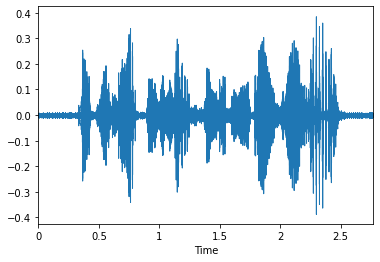

参照テキスト: IT WILL NOT BE SAFE FOR YOU TO STAY HERE NOW
ASR仮説: ENIT WILL NOT BE SAFE FOR YOU TO STAY HERE NOW
**************************************************
入力音声: ESPNet_asr_egs/en/2.wav


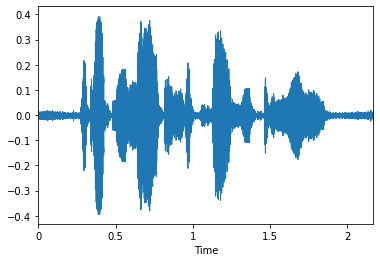

参照テキスト: IT WILL BE NO DISAPPOINTMENT TO ME
ASR仮説: ENIT WILL BE NO DISAPPOINTMENT TO ME
**************************************************
入力音声: ESPNet_asr_egs/en/3.wav


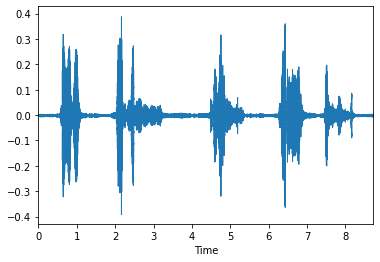

参照テキスト: HOWEVER THAT WAS OVER NOW THE TREE GONE THE STORY AT AN END
ASR仮説: ENHOWEVER THAT WAS OVER NOW THE TREE GONE THE STORY AT AN END
**************************************************
入力音声: ESPNet_asr_egs/en/4.wav


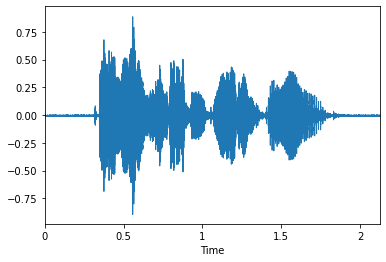

参照テキスト: ALL IS SAID WITHOUT A WORD
ASR仮説: ENALL IS SAID WITHOUT A WORD
**************************************************
入力音声: ESPNet_asr_egs/en/5.wav


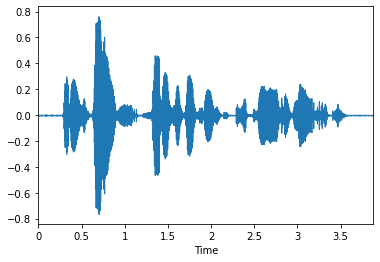

参照テキスト: IT IS THIS THAT IS OF INTEREST TO THEORY OF KNOWLEDGE
ASR仮説: ENIT IS THIS THAT IS EVENTUROUS TO THEORY OF KNOWLEDGE
**************************************************
入力音声: ESPNet_asr_egs/es/6.wav


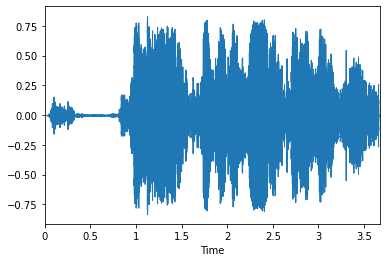

参照テキスト: HABITA EN AGUAS POCO PROFUNDAS Y ROCOSAS
ASR仮説: ESHABITA NAGUAS POCO PERFUNDAS QUE ROCOSAS
**************************************************
入力音声: ESPNet_asr_egs/es/7.wav


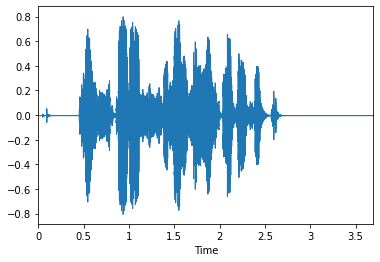

参照テキスト: LAS GUITARRAS SIGUEN EL MISMO CONCEPTO
ASR仮説: EOLAS GUITARAS SIGEN EL MISMO KONCEPTO
**************************************************
入力音声: ESPNet_asr_egs/es/8.wav


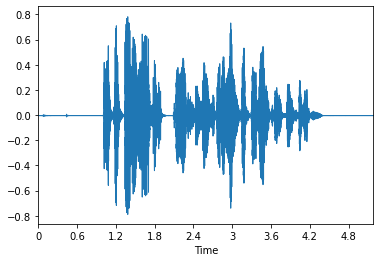

参照テキスト: ESTA PALOMA ES CONOCIDA SOLAMENTE POR RESTOS FÓSILES
ASR仮説: ESESTA PARUMA ES CONOCIDA SORAMENTE POR RESTOS FOSCILES
**************************************************
入力音声: ESPNet_asr_egs/ja/9.wav


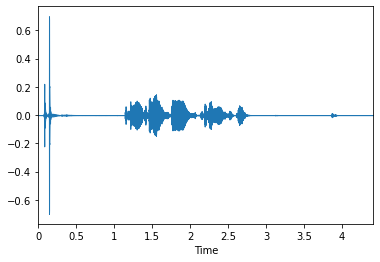

参照テキスト: 彼女は頬をふくらませた。
ASR仮説: ESCANO SOBAJÓ CRAMASETA
**************************************************
入力音声: ESPNet_asr_egs/ja/10.wav


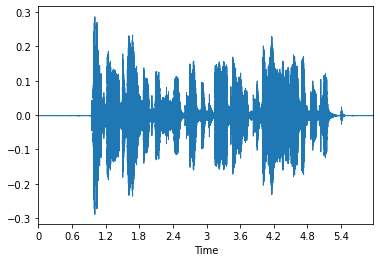

参照テキスト: 両手の指は変形し、関節の辺りが、こぶ状に盛り上がっていた。
ASR仮説: JA病田の一部屋は本気し、かせつのはたりがこころにもりだっていた。
**************************************************
入力音声: ESPNet_asr_egs/ja/11.wav


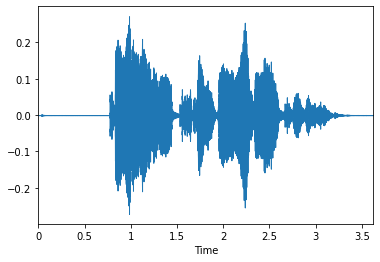

参照テキスト: 去年より今年のほうが暑いです。
ASR仮説: FAکه نویالیل کتاش نه و قعتی دست
**************************************************
入力音声: ESPNet_asr_egs/zh/12.wav


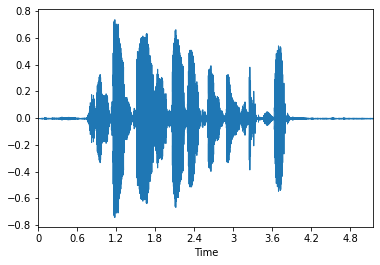

参照テキスト: 星光在微白的天空闪烁
ASR仮説: TW新光在微白的天空上所
**************************************************
入力音声: ESPNet_asr_egs/zh/13.wav


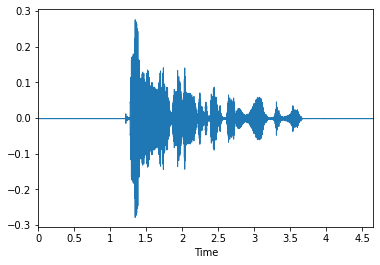

参照テキスト: 欢迎有兴趣的青年朋友
ASR仮説: TW歡迎有興趣的青年朋友
**************************************************
入力音声: ESPNet_asr_egs/zh/14.wav


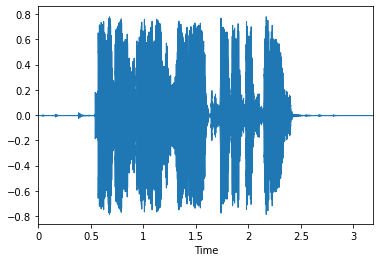

参照テキスト: 整个下午依然哭个不停
ASR仮説: TW整個下午依然哭個不停
**************************************************


In [8]:
!git clone https://github.com/ftshijt/ESPNet_asr_egs.git

import pandas as pd
import soundfile
import librosa.display
from IPython.display import display, Audio
import matplotlib.pyplot as plt


egs = pd.read_csv("ESPNet_asr_egs/egs.csv")
for index, row in egs.iterrows():
  if row["lang"] == lang or lang == "multilingual":
    speech, rate = soundfile.read("ESPNet_asr_egs/" + row["path"])
    assert fs == int(row["sr"])
    nbests = speech2text(speech)

    text, *_ = nbests[0]
    print(f"入力音声: ESPNet_asr_egs/{row['path']}")
    # サンプルを聞いてみよう
    display(Audio(speech, rate=rate))
    librosa.display.waveplot(speech, sr=rate)
    plt.show()
    print(f"参照テキスト: {text_normalizer(row['text'])}")
    print(f"ASR仮説: {text_normalizer(text)}")
    print("*" * 50)


### **自分で録音したものを認識する**
- 1   録音した音源をアップロードすることができます。
- 2   ASRシステムであなたの声を認識する

In [9]:
from google.colab import files
from IPython.display import display, Audio
import soundfile
import librosa.display
import matplotlib.pyplot as plt

uploaded = files.upload()

for file_name in uploaded.keys():
  speech, rate = soundfile.read(file_name)
  assert rate == fs, "mismatch in sampling rate"
  nbests = speech2text(speech)
  text, *_ = nbests[0]

  print(f"入力音声: {file_name}")
  display(Audio(speech, rate=rate))
  librosa.display.waveplot(speech, sr=rate)
  plt.show()
  print(f"ASR仮説: {text_normalizer(text)}")
  print("*" * 50)

### 自分のライブ録音を認識する
- 1   自分の声を録音する
- 2   ASRシステムであなたの声を認識する



マイクに向かって話す5 秒...


<IPython.core.display.Javascript object>

終わり!


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


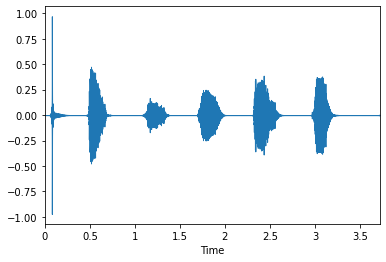

In [10]:
# from https://gist.github.com/korakot/c21c3476c024ad6d56d5f48b0bca92be

from IPython.display import Javascript
from google.colab import output
from base64 import b64decode

RECORD = """
const sleep = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec, filename='audio.wav'):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec * 1000))
  b = b64decode(s.split(',')[1])
  with open(filename, 'wb+') as f:
    f.write(b)

audio = 'audio.wav'
second = 5
print(f"マイクに向かって話す{second} 秒...")
record(second, audio)
print("終わり!")


import librosa
import librosa.display
speech, rate = librosa.load(audio, sr=16000)
librosa.display.waveplot(speech, sr=rate)

import matplotlib.pyplot as plt
plt.show()

import pysndfile
pysndfile.sndio.write('audio_ds.wav', speech, rate=rate, format='wav', enc='pcm16')

from IPython.display import display, Audio
display(Audio(speech, rate=rate))

In [11]:
nbests = speech2text(speech)
text, *_ = nbests[0]

print(f"ASR仮説: {text_normalizer(text)}")

ASR仮説: ENAH HE WOULD BE OH


/usr/local/lib/python3.8/dist-packages/espnet/nets/ctc_prefix_score.py:325: RuntimeWarning: invalid value encountered in logaddexp
  r_sum = self.xp.logaddexp(
